https://desi.lbl.gov/trac/wiki/MilkyWayWG/PipelineOutputs

https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1

In [2]:
pwd

'/global/cfs/cdirs/desi/users/apcooper/projects/quicksv1'

In [3]:
import numpy as np
import glob
import os
import sys
import re
import subprocess
import fitsio
import healpy as hp
import warnings

from importlib import reload

from astropy.io import fits
from astropy.table import Table, Column
import astropy.coordinates as coords
import astropy.units as u

import matplotlib.pyplot as pl
%matplotlib inline

In [4]:
from desitarget.sv1.sv1_targetmask import desi_mask, mws_mask, bgs_mask

In [5]:
import desi_retriever
import desi_retriever.andes

In [6]:
import quicksv
reload(quicksv)
from quicksv import MWSExposures, MWSCoadd, plot_targetid, healpix_from_table, target_healpix_path, get_images

In [7]:
d = MWSExposures(redux='sv_daily',run=210110)
d

MWS: daily-exp-210110 (/global/cfs/cdirs/desi/science/mws/redux/sv_daily/rv_output/210110/rvtab_spectra-daily.fits)

The RV table is in d.rv and the 'fibermap' in d.fm (the fibermap columns can also be accessed directly throuhg d[]). If you don't want to use those objects just load the corresponding rv and fibermap tables and substitute below.

In [8]:
# Useful derived values

pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

gmr = gmag - rmag
rmz = rmag - zmag

In [9]:
# Summary of target types
mws_class_tab = Table(np.unique(d['SV1_MWS_TARGET'],return_counts=True),names=[None,'Counts'])
col = Column([','.join(mws_mask.names(_)) if _ != 999999 else 'M31_M33' for _ in mws_class_tab['SV1_MWS_TARGET']],name='NAME')
mws_class_tab.add_column(col)
mws_class_tab

SV1_MWS_TARGET,Counts,NAME
int64,int64,str46
0,524734,
4,241,MWS_NEARBY
17,123481,"MWS_MAIN_BROAD,MWS_MAIN_BROAD_NORTH"
21,155,"MWS_MAIN_BROAD,MWS_NEARBY,MWS_MAIN_BROAD_NORTH"
33,139391,"MWS_MAIN_BROAD,MWS_MAIN_BROAD_SOUTH"
37,215,"MWS_MAIN_BROAD,MWS_NEARBY,MWS_MAIN_BROAD_SOUTH"
49152,10544,"MWS_MAIN_FAINT,MWS_MAIN_FAINT_NORTH"
49156,89,"MWS_NEARBY,MWS_MAIN_FAINT,MWS_MAIN_FAINT_NORTH"
81920,14656,"MWS_MAIN_FAINT,MWS_MAIN_FAINT_SOUTH"


In [10]:
desi_class_tab = Table(np.unique(d['SV1_DESI_TARGET'],return_counts=True),names=[None,'Counts'])
col = Column([','.join(desi_mask.names(_)) for _ in desi_class_tab['SV1_DESI_TARGET']],name='NAME')
desi_class_tab.add_column(col)
desi_class_tab

SV1_DESI_TARGET,Counts,NAME
int64,int64,str259
0,1431,
999999,13775,"LRG,ELG,QSO,LRG_OPT,LRG_IR,LRG_SV_OPT,ELG_SV_GFIB,QSO_COLOR_8PASS,QSO_HZ_F,QSO_Z5,LRG_OPT_NORTH,LRG_IR_NORTH"
1048609,3814,"LRG,LRG_SV_OPT,LRG_SV_OPT_NORTH"
1310761,658,"LRG,LRG_OPT,LRG_SV_OPT,LRG_OPT_NORTH,LRG_SV_OPT_NORTH"
2097217,1934,"LRG,LRG_SV_IR,LRG_SV_IR_NORTH"
2621521,1109,"LRG,LRG_IR,LRG_SV_IR,LRG_IR_NORTH,LRG_SV_IR_NORTH"
3145825,2085,"LRG,LRG_SV_OPT,LRG_SV_IR,LRG_SV_OPT_NORTH,LRG_SV_IR_NORTH"
3407977,1746,"LRG,LRG_OPT,LRG_SV_OPT,LRG_SV_IR,LRG_OPT_NORTH,LRG_SV_OPT_NORTH,LRG_SV_IR_NORTH"
3670129,1289,"LRG,LRG_IR,LRG_SV_OPT,LRG_SV_IR,LRG_IR_NORTH,LRG_SV_OPT_NORTH,LRG_SV_IR_NORTH"


#### Standards

In [11]:
is_std = ((d['SV1_DESI_TARGET'] & desi_mask['STD_BRIGHT']) != 0) | \
    ((d['SV1_DESI_TARGET'] & desi_mask['STD_FAINT']) != 0) | \
    ((d['SV1_DESI_TARGET'] & desi_mask['STD_WD']) != 0)
is_std.sum()

93592

In [12]:
# Some standards are  MWS targets
mws_stds = is_std & (d['SV1_MWS_TARGET'] > 0)
mws_stds.sum()

83101

In [13]:
# Some standards are not MWS targets
not_mws_stds = is_std & (d['SV1_MWS_TARGET'] == 0)
not_mws_stds.sum()

10491

#### MWS Targets

In [14]:
mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)
m31_target = d['SV1_MWS_TARGET'] == 999999

In [15]:
def spec_ok(rv,success='SUCCESS'):
    return (rv[success]) & (rv['SN_B'] > 2) & (rv['SN_R'] > 2) & (rv['SN_Z'] > 2)  & (rv['RVS_WARN'] == 0)

def mws_samples(d):
    """
    """
    pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

    gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
    rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
    zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

    gmr = gmag - rmag
    rmz = rmag - zmag
    
    is_mws_red = (rmag < 19) & (pm < 7.0) & (np.isfinite(pm)) & (gmr > 0.7)
    is_mws_blue = (rmag < 19) & (gmr < 0.7)
    is_mws_broad = (rmag < 19) & ((pm >= 7.0) | (~np.isfinite(pm))) & (gmr > 0.7)
    
    return is_mws_red,is_mws_blue,is_mws_broad

In [16]:
def plot_compare_mws_samples(prop,d,bins,decorate=None,density=False,success='SUCCESS',sel=None):
    """
    """
    is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)
    
    mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)

    specok = spec_ok(d.rv,success=success) 
    
    if sel is not None:
        specok &= sel

    h_red,_ = np.histogram(prop[is_mws_red & specok],bins=bins,density=density)
    h_blue,_ = np.histogram(prop[is_mws_blue & specok],bins=bins,density=density)
    h_broad,_ = np.histogram(prop[is_mws_broad & specok],bins=bins,density=density)

    h_red_mw,_ = np.histogram(prop[is_mws_red & specok & mws_sv_target],bins=bins,density=density)
    h_blue_mw,_ = np.histogram(prop[is_mws_blue & specok & mws_sv_target],bins=bins,density=density)
    h_broad_mw,_ = np.histogram(prop[is_mws_broad & specok & mws_sv_target],bins=bins,density=density)
    
    pl.figure(figsize=(12,6))

    pl.subplot(121)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red),drawstyle='steps-post',c='r',label='RED (all)')
        pl.plot(bins[:-1],np.log10(h_blue),drawstyle='steps-post',c='b',label='BLUE (all)')
        pl.plot(bins[:-1],np.log10(h_broad),drawstyle='steps-post',c='g',label='BROAD (all)')

    if decorate is not None:
        decorate()
    pl.title('All r < 19')
    
    pl.subplot(122)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red_mw),drawstyle='steps-post',c='r',label='SV1 MWS targets')
        pl.plot(bins[:-1],np.log10(h_blue_mw),drawstyle='steps-post',c='b')
        pl.plot(bins[:-1],np.log10(h_broad_mw),drawstyle='steps-post',c='g')

    if decorate is not None:
        decorate()
    pl.title('MWS Targets only')

    return

#### Selection diagram: all spectra

<ipython-input-17-b07e69b351b4>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


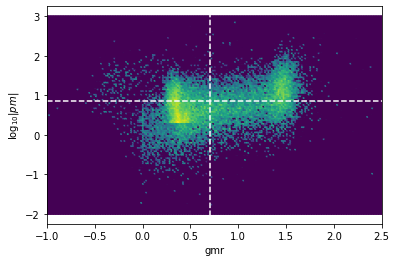

In [17]:
pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Selection diagram: MWS mag range

<ipython-input-18-7101eb1d4b7d>:3: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


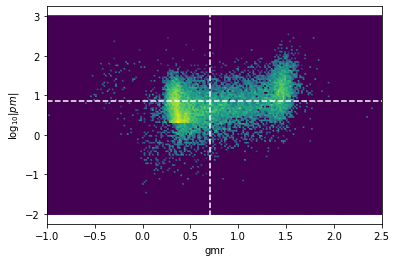

In [18]:
bright = rmag < 19
very_bright = rmag < 16
pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Selection diagram: MWS mag range and good spectra

In [19]:
bright = rmag <= 19
specok = spec_ok(d.rv)
print(specok.sum(),len(d.rv), specok.sum()/len(d.rv))
print((bright & specok).sum(),len(d.rv), (bright & specok).sum()/len(d.rv))

265212 827395 0.3205385577626164
244204 827395 0.29514802482490227


<ipython-input-20-a2dd8a284c74>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)


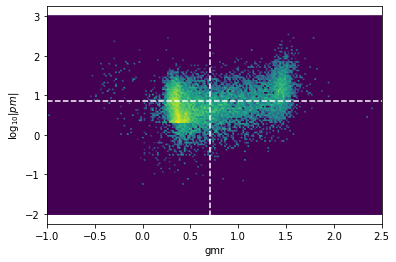

In [20]:
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

<ipython-input-21-abf5c62edd64>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok & ~is_std],np.log10(np.abs(pm[bright & specok & ~is_std])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)


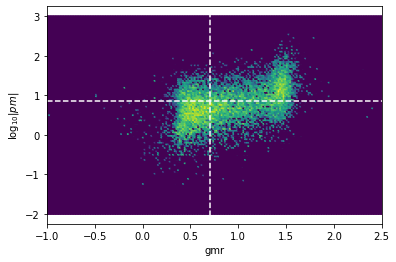

In [21]:
pl.hexbin(gmr[bright & specok & ~is_std],np.log10(np.abs(pm[bright & specok & ~is_std])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Selection diagram: Standards

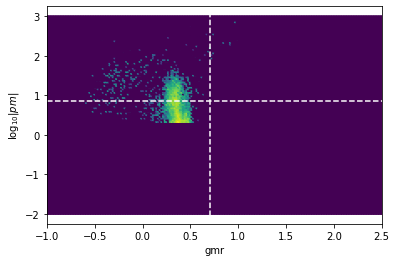

In [22]:
pl.hexbin(gmr[mws_stds],np.log10(np.abs(pm[mws_stds])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

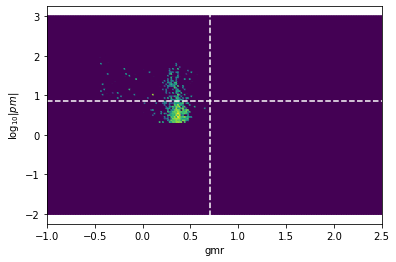

In [23]:
pl.hexbin(gmr[not_mws_stds],np.log10(np.abs(pm[not_mws_stds])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

#### Histograms

In [24]:
svmain = bright & specok & mws_sv_target & (~is_std)

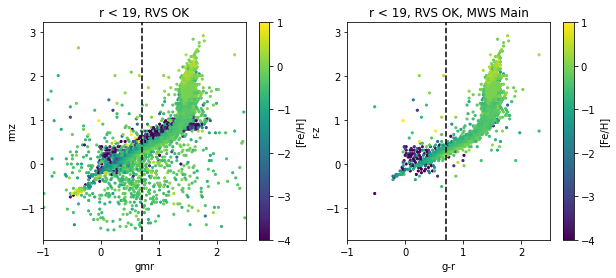

In [25]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.hexbin(gmr[bright & specok],rmz[bright & specok],
          C=d.rv['FEH'][bright & specok],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, RVS OK')

pl.subplot(1,2,2)
pl.hexbin(gmr[svmain],rmz[svmain],
          C=d.rv['FEH'][svmain],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, RVS OK, MWS Main');

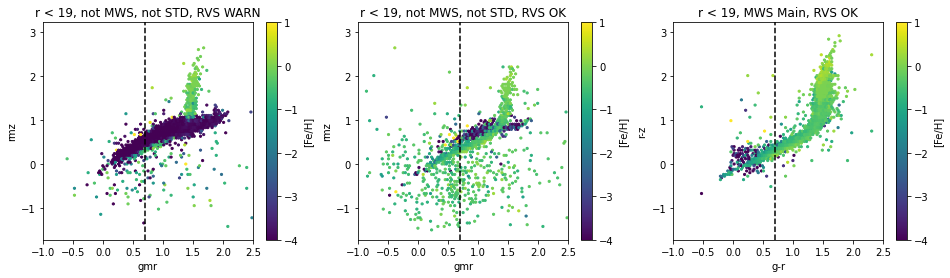

In [26]:
# Spectra that are not MWS targets
# Color is rvspecfit [Fe/H]

pl.figure(figsize=(16,4))

sel = (~mws_sv_target) & (~is_std) & (~specok) & bright  & ~very_bright
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['FEH'][sel],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, not MWS, not STD, RVS WARN')

sel = ~mws_sv_target & ~is_std & specok & bright  & ~very_bright
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['FEH'][sel],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, not MWS, not STD, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          C=d.rv['FEH'][svmain],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='[Fe/H]')
pl.title('r < 19, MWS Main, RVS OK');

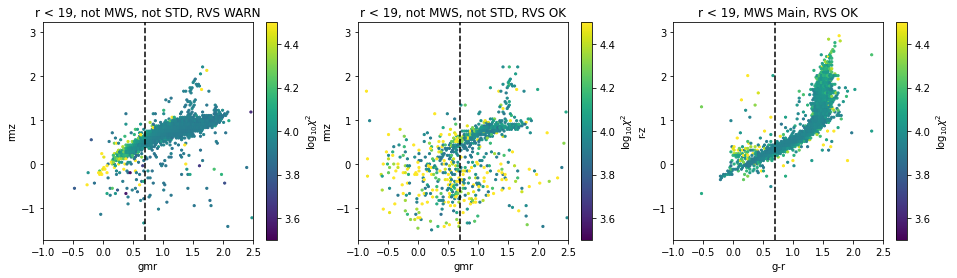

In [27]:
# Spectra that are not MWS targets
# Color is rvspecfit chi^2 

pl.figure(figsize=(16,4))

sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          C=np.log10(d.rv['CHISQ_TOT'][sel]),
          reduce_C_function=np.median,
          vmin=3.5,vmax=4.5,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label=r'$\log_{10}\chi^{2}$')
pl.title('r < 19, not MWS, not STD, RVS WARN')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          C=np.log10(d.rv['CHISQ_TOT'][sel]),
          reduce_C_function=np.median,
          vmin=3.5,vmax=4.5,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label=r'$\log_{10}\chi^{2}$')
pl.title('r < 19, not MWS, not STD, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          C=np.log10(d.rv['CHISQ_TOT'][svmain]),
          reduce_C_function=np.median,
          vmin=3.5,vmax=4.5,
          extent=(-1,2.5,-1.5,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label=r'$\log_{10}\chi^{2}$')
pl.title('r < 19, MWS Main, RVS OK');

In [28]:
# How many non-MWS targets with OK fits have type != PSF?
# Easiest to pick out for red r-z color...

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright & (rmz > 1.1)
Table(np.unique(d['MORPHTYPE'][sel],return_counts=True))

MORPHTYPE,col1
bytes4,int64
DEV,102
EXP,62
REX,95
SER,93


What fraction of these are really stars? Compare chi^2 distributions...

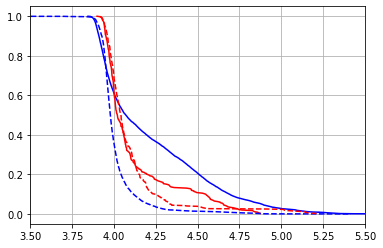

In [29]:
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright & (rmz < 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='b')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')  & ~very_bright & (rmz > 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='r')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & (rmz < 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='b',ls='--')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & (rmz > 1.1)
pl.plot(np.log10(np.sort(d.rv['CHISQ_TOT'][sel])),1-np.arange(0,sel.sum())/sel.sum(),c='r',ls='--')

pl.xlim(3.5,5.5)
pl.grid()

In [30]:
sel = mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & (rmz > 1.1)
Table(np.unique(d['MORPHTYPE'][sel],return_counts=True))

MORPHTYPE,col1
bytes4,int64
PSF,17039


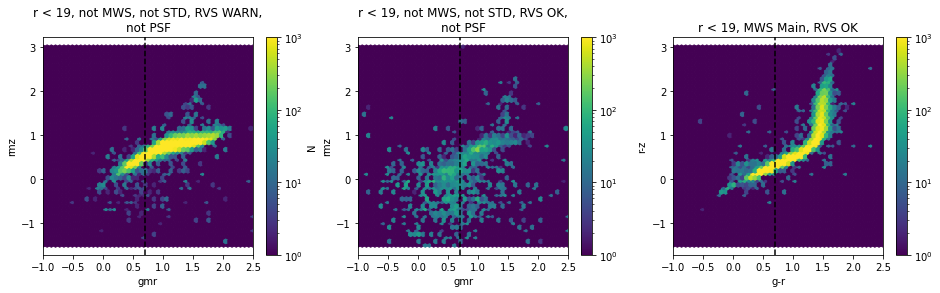

In [31]:
# Similar to previous plots but now look only at targets that are not PSF.

pl.figure(figsize=(16,4))

sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] != 'PSF')
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, RVS WARN,\nnot PSF')

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] != 'PSF')
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, RVS OK,\nnot PSF')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

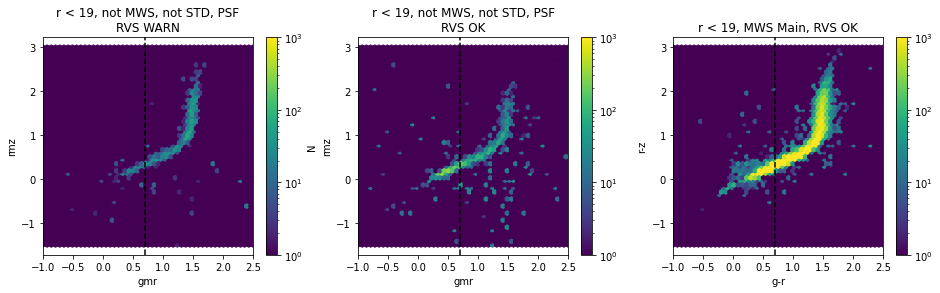

In [32]:
# Similar to previous plots but now look only at targets that *are* PSF.


pl.figure(figsize=(16,4))

# PSF in mag range but not a MW target, bad spectrum
sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] == 'PSF') & ~very_bright
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, PSF\nRVS WARN')

# PSF in mag range but not a MW target, good spectrum
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, PSF\nRVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

Clear stellar locus in the middle plot above. What are the PSF sources that are not MWS targets?

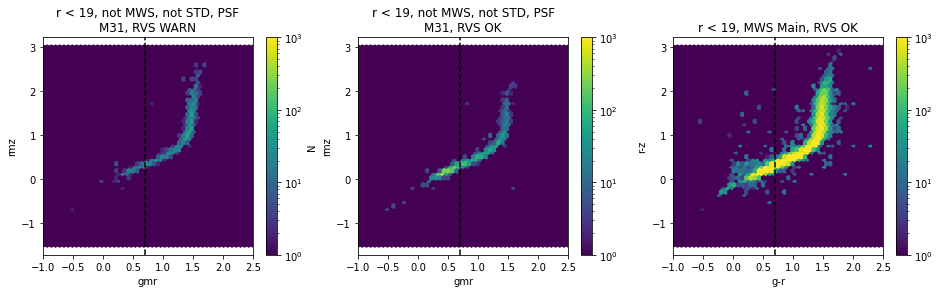

In [33]:
# Most of them are M31 targets.

pl.figure(figsize=(16,4))

# PSF in mag range but not a MW target, bad spectrum
sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] == 'PSF') & ~very_bright & m31_target
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, PSF\nM31, RVS WARN')

# PSF in mag range but not a MW target, good spectrum
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & m31_target
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, PSF\nM31, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

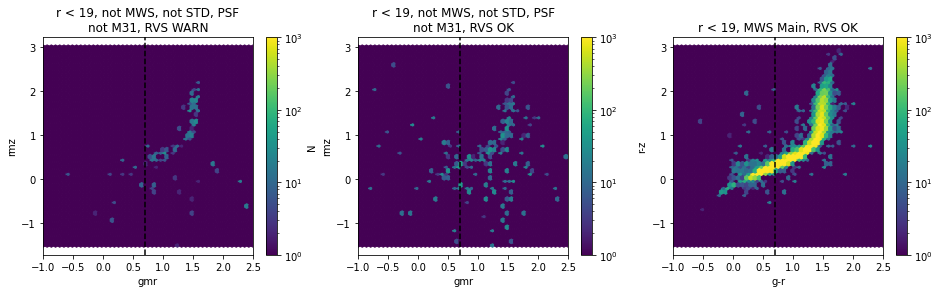

In [34]:
# The set that are not M31 targets

pl.figure(figsize=(16,4))

# PSF in mag range but not a MW target, bad spectrum
sel = (~mws_sv_target) & (~is_std) & (~specok) & bright & (d['MORPHTYPE'] == 'PSF') & ~very_bright & ~m31_target
pl.subplot(1,3,1)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar(label='N')
pl.title('r < 19, not MWS, not STD, PSF\nnot M31, RVS WARN')

# PSF in mag range but not a MW target, good spectrum
sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & ~m31_target
pl.subplot(1,3,2)
pl.hexbin(gmr[sel],rmz[sel],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, not MWS, not STD, PSF\nnot M31, RVS OK')

pl.subplot(1,3,3)
pl.hexbin(gmr[svmain],rmz[svmain],
          bins='log',vmin=1,vmax=1e3,
          extent=(-1,2.5,-1.5,3),gridsize=50)
pl.xlim(-1,2.5)
pl.xlabel('g-r')
pl.ylabel('r-z')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()
pl.title('r < 19, MWS Main, RVS OK');

In [35]:
# They are mostly BGS_ANY

sel = ~mws_sv_target & ~is_std & specok & bright & (d['MORPHTYPE'] == 'PSF')  & ~very_bright & ~m31_target

print(sel.sum())

u,c = np.unique(d[sel]['SV1_DESI_TARGET'],return_counts=True)
Table(np.array([[','.join(desi_mask.names(a)),b] for a,b in zip(u,c)]))

2252


col0,col1
str123,str123
"LRG,LRG_IR,LRG_SV_IR,LRG_IR_NORTH,LRG_SV_IR_NORTH",14
"LRG,LRG_IR,LRG_SV_OPT,LRG_SV_IR,LRG_IR_NORTH,LRG_SV_OPT_NORTH,LRG_SV_IR_NORTH",13
"QSO,QSO_COLOR_8PASS,QSO_COLOR_8PASS_NORTH",15
"QSO,QSO_COLOR_8PASS,QSO_RF_8PASS,QSO_COLOR_8PASS_NORTH,QSO_RF_8PASS_NORTH",9
"LRG,QSO,LRG_IR,LRG_SV_IR,QSO_RF_4PASS,LRG_IR_SOUTH,LRG_SV_IR_SOUTH,QSO_RF_4PASS_SOUTH",6
"LRG,QSO,LRG_IR,LRG_SV_IR,QSO_COLOR_4PASS,QSO_RF_4PASS,LRG_IR_SOUTH,LRG_SV_IR_SOUTH,QSO_COLOR_4PASS_SOUTH,QSO_RF_4PASS_SOUTH",11
"QSO,QSO_COLOR_8PASS,QSO_COLOR_8PASS_SOUTH",2
"QSO,QSO_COLOR_8PASS,QSO_RF_8PASS,QSO_COLOR_8PASS_SOUTH,QSO_RF_8PASS_SOUTH",12
BGS_ANY,2045


In [37]:
bgs = d['SV1_BGS_TARGET'] > 0

In [38]:
u,c = np.unique(d[sel & bgs]['SV1_BGS_TARGET'],return_counts=True)
Table(np.array([[','.join(bgs_mask.names(a)),b] for a,b in zip(u,c)]))

col0,col1
str51,str51
"BGS_BRIGHT,BGS_BRIGHT_NORTH",228
"BGS_LOWQ,BGS_LOWQ_NORTH",365
"BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_NORTH,BGS_LOWQ_NORTH",810
"BGS_BRIGHT,BGS_BRIGHT_SOUTH",238
"BGS_LOWQ,BGS_LOWQ_SOUTH",209
"BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_SOUTH,BGS_LOWQ_SOUTH",320


In [71]:
# Create a table for unique targets in the selection above
nodups = Table.from_pandas(d[sel].to_pandas().drop_duplicates('TARGETID'))
nodups

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes3,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39633143531045956,2,443,2443,1364,0,96.61000622110608,43.733469050027864,2.6243384,2.6980379,2021.0116,5400.0,17592186060804,1,TGT,346.09668,-188.93117,3400,0.49859168587143543,1,9011,559430,1092,PSF,14.865108,28.177917,77.35224,543.9863,4.404536,66.59902,959054961562589952,G2,18.467237,19.138796,17.671015,0.3111347,0967p437,0.14525533,60.472527,96.86416,2.4354675,0.69752055,11.568337,21.928644,60.197132,13.923179,36.493916,61.274387,64,0.0,0.0,0.0,0.0,N,3400,8,17592186060804,0,0,0,0,0,2,346.057,-188.946,-0.007,0.009,96.60997296260273,43.733434328782494,20210105,70933,59220.1772171,80675,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633152305529112,8,340,8340,4255,0,100.2821575521416,44.180631468534244,-0.16023056,-2.937039,2021.0116,5400.0,52776558182404,1,TGT,-319.32043,-77.34555,3400,0.14979385495377495,1,9011,561522,280,PSF,12.603141,32.5787,50.405582,534.9753,112.71727,115.464745,964239330687143808,G2,18.891598,19.512293,18.08736,0.92881805,1004p442,0.13303985,66.27425,63.330017,2.0256894,0.54198295,9.816048,25.374157,39.258755,9.816048,25.374157,39.258755,768,0.0,0.0,0.0,0.0,N,3400,8,52776558182404,0,0,0,0,0,2,-319.216,-77.334,-0.003,-0.005,100.282142514023,44.18065147747292,20210105,70933,59220.17721719,80675,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39627652595714859,6,373,6373,3085,0,36.48368213562547,-5.556755321762747,0.0,0.0,2021.0034,5400.0,1152921504606846976,1,TGT,-122.059105,364.25775,2000,0.69742618568907,4,9010,298865,2859,PSF,24.497648,58.893124,93.56179,354.74518,200.26947,91.6902,0,,0.0,0.0,0.0,0.0,0365m055,0.024921948,54.649155,27.25374,1e+20,1e+20,19.042692,45.779236,72.72814,65.86215,142.60582,205.74416,0,0.0,0.0,0.0,0.0,S,2000,1,1152921504606846976,131074,0,0,0,0,2,-122.047,364.207,-0.004,-0.001,36.48366624167535,-5.556751310377739,20210105,70931,59220.16168232,80635,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39627598535333330,1,372,1372,961,0,34.94752998722026,-7.785782180727855,0.0,0.0,2021.0034,5400.0,1152921504606846976,1,TGT,260.91653,-196.38145,2000,0.8487821825932937,4,9010,285976,5586,PSF,19.582611,70.43961,133.24072,354.78427,120.02042,46.96984,0,,0.0,0.0,0.0,0.0,0349m077,0.021956777,81.890114,69.15231,1e+20,1e+20,15.251372,54.85994,103.770836,68.3579,225.35484,439.13205,16,0.0,0.0,0.0,0.0,S,2000,1,1152921504606846976,131074,0,0,0,0,2,260.845,-196.322,0.003,-0.007,34.947541012206806,-7.785755006271709,20210105,70931,59220.1616822,80635,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39627706685465014,2,202,2202,1113,0,28.020354013177972,-3.226091289051856,0.0

In [72]:
_s = np.flatnonzero(d['TARGETID'] == nodups[2]['TARGETID'])
d[_s]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39627652595714859,6,373,6373,3085,0,36.48368213562547,-5.556755321762747,0.0,0.0,2021.0034,5400.0,1152921504606846976,1,TGT,-122.059105,364.25775,2000,0.69742618568907,4,9010,298865,2859,PSF,24.497648,58.893124,93.56179,354.74518,200.26947,91.6902,0,,0.0,0.0,0.0,0.0,0365m055,0.024921948,54.649155,27.25374,1e+20,1e+20,19.042692,45.779236,72.72814,65.86215,142.60582,205.74416,0,0.0,0.0,0.0,0.0,S,2000,1,1152921504606846976,131074,0,0,0,0,2,-122.047,364.207,-0.004,-0.001,36.48366624167535,-5.556751310377739,20210105,70931,59220.16168232,80635,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999


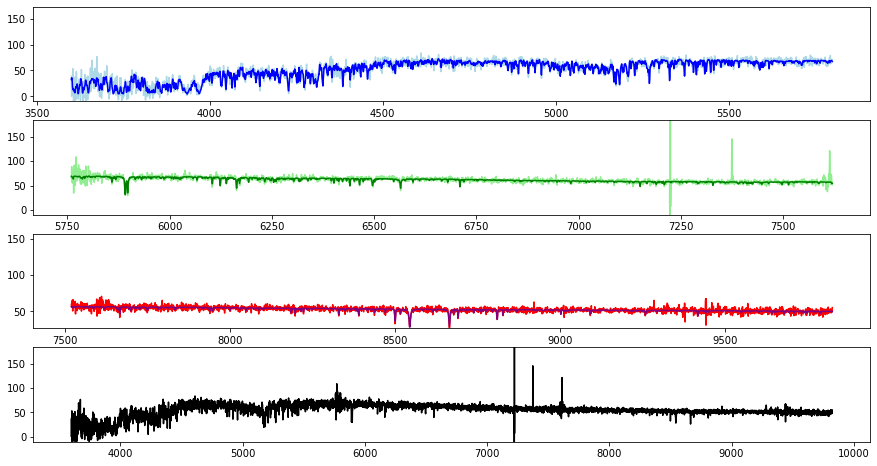

In [73]:
get_images(d[_s])
plot_targetid(d,d[_s]['TARGETID']);

In [74]:
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))

In [75]:
# This object doesn't have any REF_CAT or associated Gaia parameters, despite being in DR2 according to the viewer.
Table(targets[targets['TARGETID'] == d[_s]['TARGETID']])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float64,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
9010,298865,0365m055,2859,PSF,36.48368213562547,85813665000000.0,-5.556755321762747,87208970000000.0,1817777.1 .. 0.0,0.024921948,24.497648,58.893124,93.56179,354.74518,200.26947,91.6902,0.9288816,0.95151925,0.97258556,3.358578,2.5435107,1.8959131,0.054151885,1.6967826e-05,3.9280523e-05,0.99999994,1.0,1.0,10,9,10,4799.558,2842.401,394.56363,3003.1987,1644.9803,202.58905,54.649155,27.25374,-11.337252,-363.02057,1.4733796,0.5393692,0.0015094012,1.982105e-05,0.99578536,0.9974096,0.999447,0.99979115,0,0,0,19.042692,45.779236,72.72814,65.86215,142.60582,205.74416,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,39627652595714859,1152921504606846976,131074,0,0.19954017378060862,4,2100,1,17683


In [76]:
_s = np.flatnonzero(d['TARGETID'] == nodups[3]['TARGETID'])
d[_s[0]]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39627598535333330,1,372,1372,961,0,34.94752998722026,-7.785782180727855,0.0,0.0,2021.0034,5400.0,1152921504606846976,1,TGT,260.91653,-196.38145,2000,0.8487821825932937,4,9010,285976,5586,PSF,19.582611,70.43961,133.24072,354.78427,120.02042,46.96984,0,,0.0,0.0,0.0,0.0,0349m077,0.021956777,81.890114,69.15231,1e+20,1e+20,15.251372,54.85994,103.770836,68.3579,225.35484,439.13205,16,0.0,0.0,0.0,0.0,S,2000,1,1152921504606846976,131074,0,0,0,0,2,260.845,-196.322,0.003,-0.007,34.947541012206806,-7.785755006271709,20210105,70931,59220.1616822,80635,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999


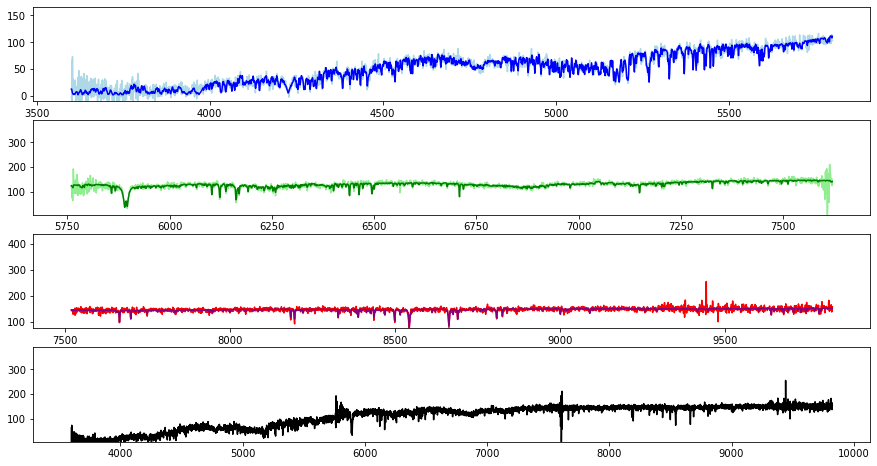

In [77]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [78]:
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))

In [79]:
# Similar story... no DR2 data in target table
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float64,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
9010,285976,0349m077,5586,PSF,34.94752998722026,61746102000000.0,-7.785782180727855,96010605000000.0,1661705.1 .. 0.0,0.021956777,19.582611,70.43961,133.24072,354.78427,120.02042,46.96984,0.9370707,0.95716196,0.9758075,4.1671124,3.3616257,3.088021,2.7067188e-05,2.5901356e-05,0.089480266,0.9951019,0.9999999,0.99928254,10,8,10,4717.5815,2833.9988,362.17206,2888.384,1568.6395,190.65845,81.890114,69.15231,-107.09293,4358.8794,0.78061754,0.3760861,0.0015817472,2.1161428e-05,0.9962859,0.99771744,0.99951273,0.999816,0,0,0,15.251372,54.85994,103.770836,68.3579,225.35484,439.13205,0.0,0,0,16,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S,39627598535333330,1152921504606846976,131074,0,0.5999528640034225,4,2100,1,17668


In [80]:
# A large fraction are not in MWS because they are missing a ref cat
np.unique(nodups['REF_CAT'],return_counts=True)

(<Column name='REF_CAT' dtype='bytes2' length=2>
   
 G2,
 array([176,  58]))

In [82]:
not_gaia = d['REF_CAT'] == ''

In [83]:
np.unique(d[sel & not_gaia]['TILEID'],return_counts=True)

(<Column name='TILEID' dtype='int32' length=35>
 80611
 80612
 80613
 80614
 80616
 80617
 80618
 80619
 80624
 80626
 80627
 80628
   ...
 80646
 80650
 80653
 80654
 80655
 80656
 80660
 80662
 80663
 80664
 80666
 80693,
 array([ 48,  29, 180,  44, 163, 116, 144,  38,  20,   5,  18,   2,   8,
          5,  30,   4,  16,  49, 118, 144,  70,  84,  16,  35, 109,  22,
          9,  74,  14,   9,   5,   9,   2,   9,   8]))

In [84]:
u,c = np.unique(d[sel & bgs & ~not_gaia]['SV1_BGS_TARGET'],return_counts=True)
Table(np.array([[','.join(bgs_mask.names(a)),b] for a,b in zip(u,c)]))

col0,col1
str51,str51
"BGS_BRIGHT,BGS_BRIGHT_NORTH",7
"BGS_LOWQ,BGS_LOWQ_NORTH",30
"BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_NORTH,BGS_LOWQ_NORTH",436
"BGS_BRIGHT,BGS_BRIGHT_SOUTH",26
"BGS_LOWQ,BGS_LOWQ_SOUTH",3
"BGS_BRIGHT,BGS_LOWQ,BGS_BRIGHT_SOUTH,BGS_LOWQ_SOUTH",12


In [85]:
# Create a table for unique targets in the selection above
nodups = Table.from_pandas(d[sel & bgs & ~not_gaia].to_pandas().drop_duplicates('TARGETID'))
nodups

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes3,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39628133581722807,1,211,1211,567,0,115.4838432749691,14.520848621323623,0.017145112,-0.1362495,2021.0034,5400.0,1152921504606846976,1,TGT,124.35461,-242.31035,2000,0.9844936265457489,4,9010,413541,5303,PSF,35.77424,56.29384,66.65471,420.34024,129.8352,84.224846,3164718137769975680,G2,18.73658,18.528803,17.571806,0.21562871,1154p145,0.046428047,17.036968,-1.1186745,1e+20,1e+20,27.808617,43.75925,51.81313,29.949644,47.943775,57.7012,0,0.0,0.0,0.0,0.0,S,2000,1,1152921504606846976,131074,0,0,0,0,2,124.323,-242.275,-0.002,0.0,115.48383500186803,14.52084870599824,20210106,71113,59221.3219787,80644,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633345008634947,4,126,4126,2209,0,105.55008236782996,56.69544305503319,-9.052883,1.2864734,2020.9624,5400.0,1152921504606846976,1,TGT,160.26613,148.55647,2000,0.961585791637541,4,9011,607466,3139,PSF,188.23665,363.98636,310.91116,19.580086,4.1428905,0.115804024,1000412477261070976,G2,17.062557,--,--,0.61292505,1054p567,0.051316544,137.98683,70.37708,1e+20,1e+20,146.37268,283.03555,241.7643,146.38268,283.0468,241.78352,2204,0.0,0.0,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,160.222,148.555,0.007,-0.004,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633341669967833,4,72,4072,2478,0,105.78825563772115,56.55033216216445,-0.23083869,0.45478973,2020.9624,5400.0,1152921504606846976,1,TGT,128.05347,111.65053,2000,0.9779846513727071,4,9011,606670,2009,PSF,69.225006,192.2254,125.025536,9.105178,4.625091,0.37820834,1000407392019986944,G2,17.812984,--,--,0.4482391,1057p565,0.05432146,51.980007,27.42295,1e+20,1e+20,53.90347,149.68024,97.35369,227.2062,318.85275,398.3571,2204,0.0,0.0,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,128.02,111.643,0.005,0.0,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633321180792983,9,320,9320,4525,0,108.1994386900014,55.11727899821825,0.35906473,-7.04212,2020.9624,5400.0,1152921504606846976,1,TGT,-207.5,-243.97255,2000,0.9349911265341121,4,9011,601785,2199,PSF,7.482564,39.444862,53.934597,28.439358,7.184022,50.029423,988035790264327936,G2,19.19037,18.959795,17.151505,1.4954382,1082p550,0.07463296,73.894356,17.925905,1e+20,1e+20,5.8112245,30.634277,41.88752,5.811239,30.634295,41.887558,2156,0.0,0.0,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,-207.469,-243.918,0.008,-0.001,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633152301334906,8,180,8180,4157,0,99.93637223934805,44.35309517943554,-1.0

In [86]:
_s = np.flatnonzero(d['TARGETID'] == nodups[2]['TARGETID'])
print(rmag[_s][0])
d[_s][0]

16.790474


TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39633341669967833,4,72,4072,2478,0,105.78825563772115,56.55033216216445,-0.23083869,0.45478973,2020.9624,5400.0,1152921504606846976,1,TGT,128.05347,111.65053,2000,0.9779846513727071,4,9011,606670,2009,PSF,69.225006,192.2254,125.025536,9.105178,4.625091,0.37820834,1000407392019986944,G2,17.812984,nan,nan,0.4482391,1057p565,0.05432146,51.980007,27.42295,1e+20,1e+20,53.90347,149.68024,97.35369,227.2062,318.85275,398.3571,2204,0.0,0.0,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,128.02,111.643,0.005,0.0,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999


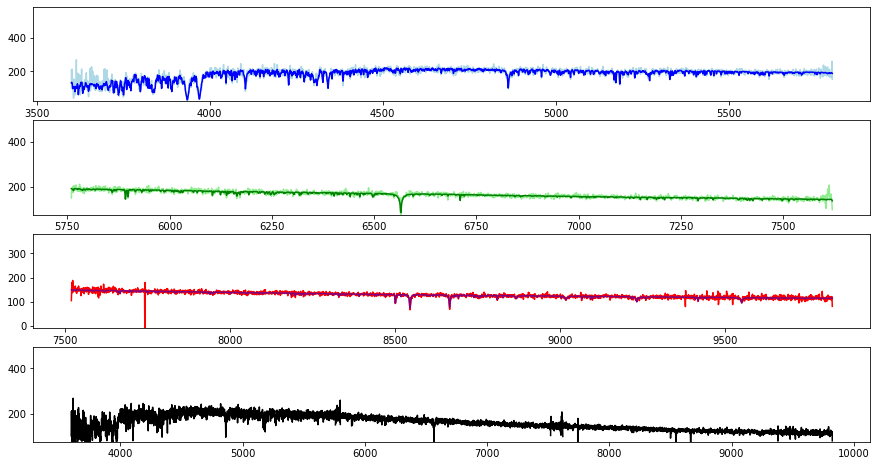

In [87]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [88]:
# In this case large fracmasked
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float64,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
9011,606670,1057p565,2009,PSF,105.78825627315977,65506975000000.0,56.55033147210231,112286534000000.0,178683.33 .. 0.0,0.05432146,69.225006,192.2254,125.025536,9.105178,4.625091,0.37820834,0.85146016,0.8973412,0.9412103,6.1299624,1.7037886,3.4042747,0.6201151,0.6463279,0.908791,0.9999997,0.9999999,1.0000013,3,3,3,230.11444,102.134254,0.0,189.7563,71.377914,0.0,51.980007,27.42295,83.62465,424.8042,0.9924786,0.49588594,0.001117859,1.4910153e-05,0.9908364,0.99436235,0.998795,0.9995448,0,0,2,53.90347,149.68024,97.35369,227.2062,318.85275,398.3571,2015.5,0,0,2204,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000407392019986944,G2,17.812984,352.1734,nan,nan,nan,nan,nan,0.7832421,False,0.7821008,31.0,0.4482391,11.999435,-0.23083869,1.9905787,0.45478973,3.2108781,N,39633341669967833,1152921504606846976,2570,0,0.8109036914442643,4,2100,1,7108


In [89]:
_s = np.flatnonzero(d['TARGETID'] == nodups[0]['TARGETID'])
print(rmag[_s][0])
d[_s][0]

18.123848


TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39628133581722807,1,211,1211,567,0,115.4838432749691,14.520848621323623,0.017145112,-0.1362495,2021.0034,5400.0,1152921504606846976,1,TGT,124.35461,-242.31035,2000,0.9844936265457489,4,9010,413541,5303,PSF,35.77424,56.29384,66.65471,420.34024,129.8352,84.224846,3164718137769975680,G2,18.73658,18.528803,17.571806,0.21562871,1154p145,0.046428047,17.036968,-1.1186745,1e+20,1e+20,27.808617,43.75925,51.81313,29.949644,47.943775,57.7012,0,0.0,0.0,0.0,0.0,S,2000,1,1152921504606846976,131074,0,0,0,0,2,124.323,-242.275,-0.002,0.0,115.48383500186803,14.52084870599824,20210106,71113,59221.3219787,80644,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999


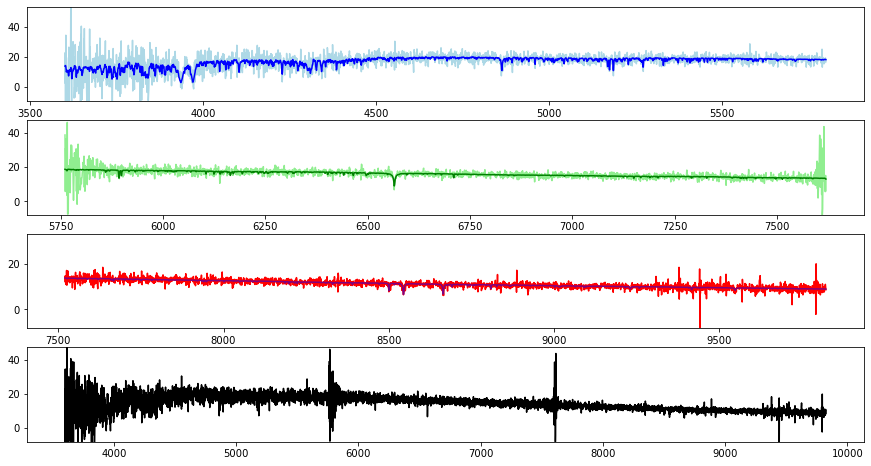

In [90]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [91]:
# In this case Gaia duplicated source = True
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float64,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
9010,413541,1154p145,5303,PSF,115.48384323727147,56064910000000.0,14.52084883842398,94610100000000.0,1323595.6 .. 0.0,0.046428047,35.77424,56.29384,66.65471,420.34024,129.8352,84.224846,0.8715897,0.91157687,0.9495334,0.09608766,0.10192541,0.11661943,0.0028348577,0.0025739362,0.005705567,0.9988935,0.9989674,0.9985582,5,4,4,2109.3857,713.9873,156.79868,1382.7916,401.00027,84.172554,17.036968,-1.1186745,-243.72768,3283.5125,2.4166915,0.6145303,0.0008139169,1.061634e-05,0.9921627,0.9951796,0.99897,0.99961096,0,0,0,27.808617,43.75925,51.81313,29.949644,47.943775,57.7012,2015.5,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3164718137769975680,G2,18.73658,165.87877,18.528803,36.725563,17.571806,48.568607,2.133273,1.9309412,True,0.9282,31.0,0.21562871,3.5244794,0.017145112,1.0991533,-0.1362495,1.638621,S,39628133581722807,1152921504606846976,131074,0,0.9589778480046269,4,2100,1,22486


In [92]:
_s = np.flatnonzero(d['TARGETID'] == nodups[1]['TARGETID'])
print(rmag[_s][0])
d[_s][0]

16.097286


TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39633345008634947,4,126,4126,2209,0,105.55008236782996,56.69544305503319,-9.052883,1.2864734,2020.9624,5400.0,1152921504606846976,1,TGT,160.26613,148.55647,2000,0.961585791637541,4,9011,607466,3139,PSF,188.23665,363.98636,310.91116,19.580086,4.1428905,0.115804024,1000412477261070976,G2,17.062557,nan,nan,0.61292505,1054p567,0.051316544,137.98683,70.37708,1e+20,1e+20,146.37268,283.03555,241.7643,146.38268,283.0468,241.78352,2204,0.0,0.0,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,160.222,148.555,0.007,-0.004,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999


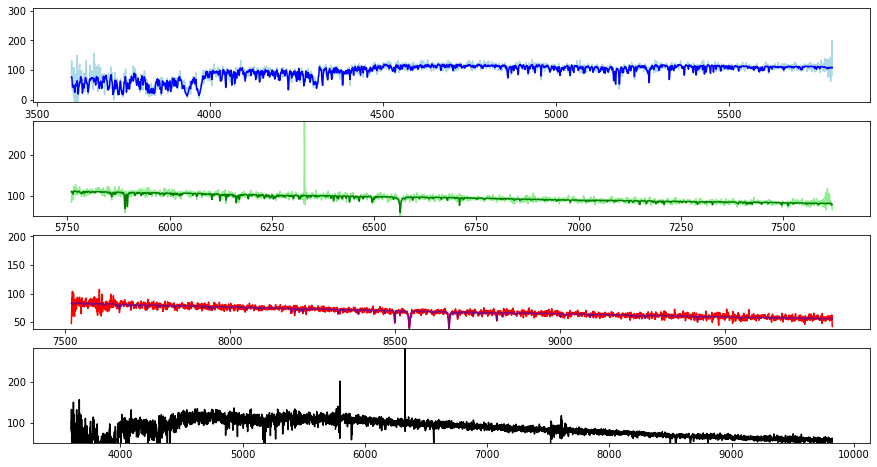

In [93]:
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);

In [94]:
# In this case large fracmasked
targets = fits.getdata(target_healpix_path(healpix_from_table(d[_s][0])))
Table(targets[targets['TARGETID'] == d[_s[0]]['TARGETID']])

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float64,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
9011,607466,1054p567,3139,PSF,105.55010738403918,208964320000000.0,56.695441103042185,133336110000000.0,275535.12 .. 0.0,0.051316544,188.23665,363.98636,310.91116,19.580086,4.1428905,0.115804024,0.8590678,0.90273416,0.9443702,0.69987684,0.0942122,0.08358285,0.4619556,0.63549757,0.9447374,0.9999997,1.0000008,0.99999994,3,3,3,225.7699,99.88388,0.0,186.9,70.16982,0.0,137.98683,70.37708,1.1234698,1267.8256,0.5465701,0.30107746,0.0011192063,1.4800876e-05,0.99134105,0.9946734,0.99886155,0.99957,0,0,2,146.37268,283.03555,241.7643,146.38268,283.0468,241.78352,2015.5,0,0,2204,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000412477261070976,G2,17.062557,587.76996,nan,nan,nan,nan,nan,0.0,True,0.7700613,31.0,0.61292505,87.64448,-9.052883,3.305249,1.2864734,2.2333004,N,39633345008634947,1152921504606846976,2570,0,0.6700490589357954,4,2100,1,7108


In [95]:
targets['GAIA_DUPLICATED_SOURCE'].sum()

2277

In [96]:
fails_fracmasked = (targets['FRACMASKED_G'] > 0.5) | (targets['FRACMASKED_R'] > 0.5) 

In [97]:
len(targets)

388209

In [98]:
fails_fracmasked.sum()

4604

In [104]:
targets_gmag = 22.5-2.5*np.log10(targets['FLUX_G'])
targets_rmag = 22.5-2.5*np.log10(targets['FLUX_R'])
targets_rmag_ok = targets['FLUX_R'] > 0
targets_rnobs_ok = targets['NOBS_R'] > 0
targets_aen_ok = targets['GAIA_ASTROMETRIC_EXCESS_NOISE'] < 3
targets_psf = targets['MORPHTYPE'] == 'PSF'
targets_have_gaia = targets['REF_CAT'] == 'G2'

<ipython-input-104-7fabd3cd08bf>:1: RuntimeWarning: divide by zero encountered in log10
  targets_gmag = 22.5-2.5*np.log10(targets['FLUX_G'])
<ipython-input-104-7fabd3cd08bf>:1: RuntimeWarning: invalid value encountered in log10
  targets_gmag = 22.5-2.5*np.log10(targets['FLUX_G'])
<ipython-input-104-7fabd3cd08bf>:2: RuntimeWarning: divide by zero encountered in log10
  targets_rmag = 22.5-2.5*np.log10(targets['FLUX_R'])


In [100]:
targets_in_mag_range = targets_psf & targets_rmag_ok & targets_rnobs_ok & (targets_rmag > 16) & (targets_rmag < 19)

In [101]:
targets_in_mag_range.sum(), (targets_in_mag_range & fails_fracmasked).sum()

(167011, 484)

In [109]:
# All potential targets in MWS mag range that fail the fracmasked cuts but have gaia data
Table(targets[targets_in_mag_range & fails_fracmasked & targets_have_gaia])['RA','DEC','REF_CAT','GAIA_DUPLICATED_SOURCE','GAIA_ASTROMETRIC_EXCESS_NOISE','FRACMASKED_R','FRACMASKED_G']

RA,DEC,REF_CAT,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_EXCESS_NOISE,FRACMASKED_R,FRACMASKED_G
float64,float64,str2,bool,float32,float32,float32
104.64593948505835,54.707501020956855,G2,False,2.6871734,0.5268217,0.57314
104.47241643208902,54.76356971839178,G2,False,0.6743169,0.97654516,0.9267766
104.65408716483466,54.903500182310395,G2,False,0.955299,0.9166679,0.5234385
103.8438419648123,55.45663560317964,G2,False,1.8131357,0.96087104,0.2295243
104.540895652981,55.86519453950276,G2,False,1.0865474,0.9593495,0.69762677
103.92246833436971,55.948749468486184,G2,False,0.8657632,0.9897326,0.9883784
102.67581275874326,55.48878203554542,G2,False,0.0,0.57554144,0.23818263
102.14152381760985,55.95488595179229,G2,False,0.04946962,0.99661285,0.63181925
102.02515442877478,56.047352185826966,G2,False,0.23506317,0.5270226,0.6048095


In [108]:
# All potential targets in MWS mag range that fail the fracmasked cuts but do not have gaia data (according to sweeps)
Table(targets[targets_in_mag_range & fails_fracmasked & ~targets_have_gaia])['RA','DEC','REF_CAT','FRACMASKED_R','FRACMASKED_G']

RA,DEC,REF_CAT,FRACMASKED_R,FRACMASKED_G
float64,float64,str2,float32,float32
98.6823397912574,59.57506937420388,,0.7416288,0.7953952
98.2581885155284,59.05685881676947,,0.9161773,0.9087866
98.22646639288581,57.57143718764851,,0.8084553,0.68522793
99.02039210591042,59.727819713645864,,0.7340669,0.74608886
99.02445658912055,59.66403852551464,,0.8100299,0.9221216
97.94075716408408,57.66864987396623,,0.7472769,0.33010548
98.14646465854008,57.7216415547856,,0.8251627,0.6797982
97.92410996596298,58.78598462462447,,0.66342163,0.6436505
97.93302648944075,58.75839856558361,,0.6413738,0.50391215


Do spectra from targets that just narrowly pass the fracmask cuts in either band look ok?

In [131]:
just_fails_fracmasked = ((targets['FRACMASKED_G'] > 0.4) & (targets['FRACMASKED_G'] < 0.5)) | ((targets['FRACMASKED_R'] > 0.4) & (targets['FRACMASKED_R'] < 0.5) )

In [132]:
mids, a1, a2 = np.intersect1d(targets[just_fails_fracmasked]['TARGETID'],d['TARGETID'],return_indices=True)
d[a2]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,NIGHT,EXPID,MJD,TILEID,EXPTIME,NUMTARGET,CMX_TARGET,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,HPXPIXEL
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int16,int64,float32,float32,float32,float32,int64
39633324620124190,2,294,2294,1094,0,104.79438452635856,55.33548802945828,0.0,0.0,2020.9624,5400.0,1152921504606846976,1,TGT,277.6482,-186.42421,2000,0.9446510669195131,4,9011,602605,4126,REX,34.566715,46.704933,32.626717,14.4906645,5.8566957,2.5080078,0,,0.0,0.0,0.0,0.0,1046p552,0.053744297,23.43189,-1.5074464,1e+20,1e+20,1.4048415,1.8981562,1.325997,1.4048898,1.8982148,1.3260114,2156,1.0,3.81644,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,277.577,-186.411,-0.0,-0.001,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633331498782611,2,428,2428,1235,0,104.32544291144119,55.63691640557221,0.0,0.0,2020.9624,5400.0,1152921504606846976,1,TGT,342.9845,-109.16167,2000,0.9308394230159478,4,9011,604245,3987,REX,710.57635,772.9916,402.23172,9.877798,3.4268599,1.3508323,1000014797651168640,G2,15.068496,15.342469,14.589569,0.0,1041p557,0.050018214,309.25867,167.69872,1e+20,1e+20,328.61044,357.47476,186.01457,328.61118,357.47546,186.01457,2204,1.0,0.58176416,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,342.917,-109.14,-0.002,-0.004,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633331502973568,2,386,2386,1217,0,104.43518607058459,55.721529736385946,1.3138438,1.9190645,2020.9624,5400.0,1152921504606846976,1,TGT,325.32767,-88.13702,2000,0.9080919999419351,4,9011,604246,640,REX,765.8106,750.26196,390.71274,9.16388,3.531897,1.7824464,1000014179175860352,G2,15.079863,15.299416,14.66211,-0.17516032,1045p557,0.051227655,232.80045,125.973076,1e+20,1e+20,359.91028,352.6028,183.62442,359.91028,352.6028,183.62442,2204,1.0,0.56906766,0.0,0.0,N,2000,1,1152921504606846976,2570,0,0,0,0,2,325.268,-88.116,-0.007,-0.004,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633345008632567,4,149,4149,2228,0,105.27012682718671,56.69658171247666,6.3702116,-5.1808743,2020.9624,5400.0,2305843017803628544,3,TGT,198.84709,150.28278,1100,0.5502158030967412,7,9011,607466,759,PSF,25.22274,36.259598,39.500187,156.45378,44.82657,61.281357,1000421990614282240,G2,18.730383,18.975096,18.230015,0.30031875,1054p567,0.051712465,-14.08565,-5.1009254,1e+20,1e+20,19.611473,28.192976,30.712635,19.611473,28.192976,30.712635,2062,0.0,0.0,0.0,0.0,N,1100,1,2305843017803628544,0,17,0,0,0,2,198.8,150.287,0.002,-0.003,0.0,0.0,20201220,69042,59204.22354176,80613,1e+20,16959,999999,1e+20,1e+20,1e+20,1e+20,999999
39633345008634947,4,126,4126,2209,0,105.55008236782996,56.69544305503319,-9.052883,1.2864734,2020.9624,5400.0,115292

In [133]:
Table(targets[just_fails_fracmasked])['FRACMASKED_R','FRACMASKED_G'][a1]

FRACMASKED_R,FRACMASKED_G
float32,float32
0.41662067,0.44361347
0.64395195,0.47168264
0.6402526,0.47868648
0.41975316,0.41912973
0.63549757,0.4619556
0.48512065,0.47190085
0.47858366,0.012357471


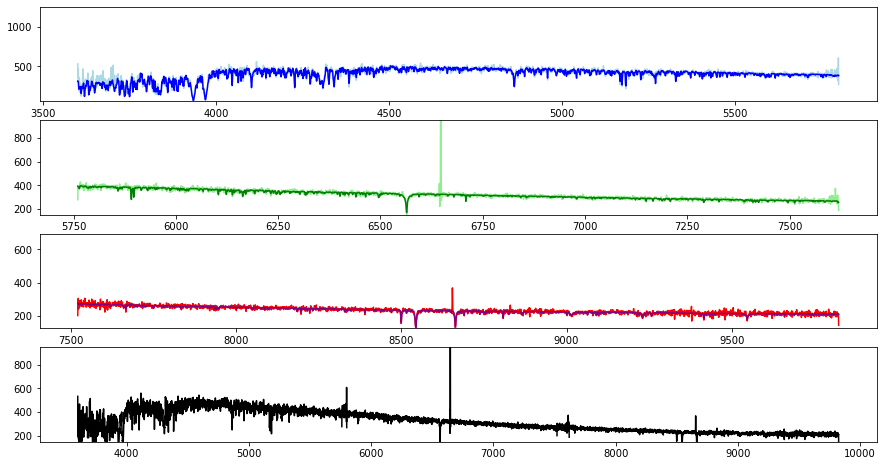

In [134]:
_s = np.flatnonzero(d['TARGETID'] == 39633348334718777)
get_images([d[_s][0]])
plot_targetid(d,d[_s[0]]['TARGETID']);